# **My electrophoresis sense is tingling. 🕷️ Predicting maintenance.**

---
## **Overview**
* Dataset source : E-coating ultrafiltration maintenance sensors dataset for a 20 year old electrophoresis plant
* Dataset type : multivariate time series
* Goal : predict the flow rate (`FM1`) using sensor readings from the past 3 hours

\
⚠️ **NOTE** : This is not an end to end project. It is an experiment to use neural networks to predict time series data.


## **The problem**
In manufacturing plants machinery will require maintenance over time. The problem is that if there is no maintenance then there will be failures, potential injuries and costs associated for repairs.

The other downside is staffing. If you do not have predictive maintenance inplace and it is important to fix problems ASAP then you will require skilled staff available almost 24/7, that in inefficient use of budget and people's time. With predictive maintenance you may not be able to be 100% accurate but even if it's 80% accurate I see that as a win given the efficiency gains.

## **Setup**
`fast.ai` has a number of unofficial extensions that people have developed. I'm using `tsai` [repo here](https://github.com/timeseriesAI/tsai) which focuses on time series. It was created by *Ignacio Oguiza*.

Some examples of uses/functions are:
* Classification, regression and forecasting
* Prepping time series data appropriately
* Converting time series datasets into images

Along with this library there are some other libraries used for plotting and data processing.


In [1]:
!pip install tsai -Uqq --upgrade # Colab was used hence the install

     |████████████████████████████████| 143kB 17.3MB/s 
     |████████████████████████████████| 5.7MB 23.3MB/s 
     |████████████████████████████████| 2.5MB 46.2MB/s 
     |████████████████████████████████| 22.3MB 1.2MB/s 
     |████████████████████████████████| 3.2MB 54.3MB/s 
     |████████████████████████████████| 92kB 11.6MB/s 
     |████████████████████████████████| 194kB 51.8MB/s 
     |████████████████████████████████| 215kB 58.4MB/s 
     |████████████████████████████████| 901kB 53.7MB/s 
     |████████████████████████████████| 9.5MB 45.3MB/s 
     |████████████████████████████████| 25.3MB 144kB/s 
     |████████████████████████████████| 675kB 46.1MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 


In [2]:
from tsai.all import * # tsai
import pandas as pd # Data processing
import seaborn as sns # Plots

sns.set(rc = {'figure.figsize':(15, 10)}) # Set figure size for all plots

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## **Data**
The data is from a electrophoresis painting plant that is 20 years old. The dataset is for a 7 year period where sensors are used to log the following sensor values every 30 minutes:
* **Pressure** - `PE1`, `PE2`, `PE3`, `PE4`
* **Temperature** - `TP1`, `TP2`
* **Flow** - `FM1` (target)

The data has already been normalised hence very little preprocess is required.

In [3]:
manual = pd.read_csv("manual_30min_norm.csv") # Read in data

manual["TIME"] = pd.to_datetime(manual["TIME"], infer_datetime_format = True) # Make sure TIME is in datetime format

In [4]:
manual

,TIME,FM1,PE1,PE2,PE3,PE4,TP1,EPOCH
0,2013-09-16 00:00:00,1.000000,0.538461,0.538461,0.123077,0.123077,0.142857,1379289600
1,2013-09-16 00:30:00,0.999475,0.538416,0.538416,0.123077,0.122985,0.143787,1379291400
2,2013-09-16 01:00:00,0.998950,0.538370,0.538370,0.123077,0.122894,0.144717,1379293200
3,2013-09-16 01:30:00,0.998424,0.538324,0.538324,0.123077,0.122802,0.145647,1379295000
4,2013-09-16 02:00:00,0.997899,0.538278,0.538278,0.123077,0.122711,0.146577,1379296800
...,...,...,...,...,...,...,...,...
110636,2020-01-07 22:00:00,0.235294,0.492308,0.553846,0.523077,0.400000,0.535715,1578434400
110637,2020-01-07 22:30:00,0.235294,0.492308,0.553846,0.523077,0.400000,0.535715,1578436200
110638,2020-01-07 23:00:00,0.235294,0.492308,0.553846,0.523077,0.400000,0.535715,1578438000
110639,2020-01-07 23:30:00,0.235294,0.492308,0.553846,0.523077,0.400000,0.535715,1578439800


## **Plots**


Before plotting and modelling I need to see if all data points have the same duration between them (they do).

In [5]:
time_diff = manual["TIME"] - manual["TIME"].shift() # Take the current row and subtract the adjacent row
time_diff.unique() # Get all unique durations between times

array([        'NaT', 1800000000000], dtype='timedelta64[ns]')

The data can be plotted as such.

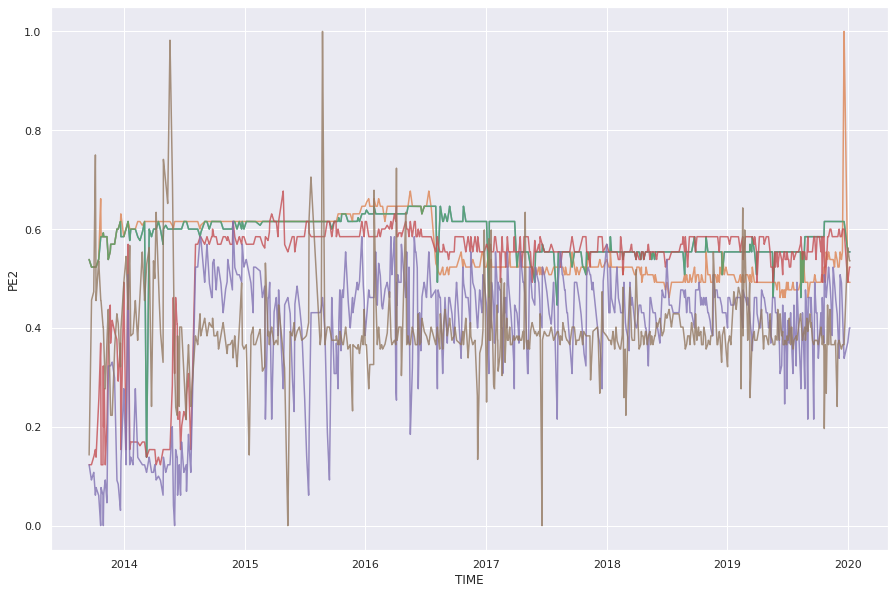

In [6]:
for col in ["PE2", "PE1",	"PE2", "PE3", "PE4", "TP1"]:
  sns.lineplot(data = manual, x = "TIME", y = col, alpha = 0.8)

Looking at the `FM1` values will help decide whether or not to **weight the loss function**.

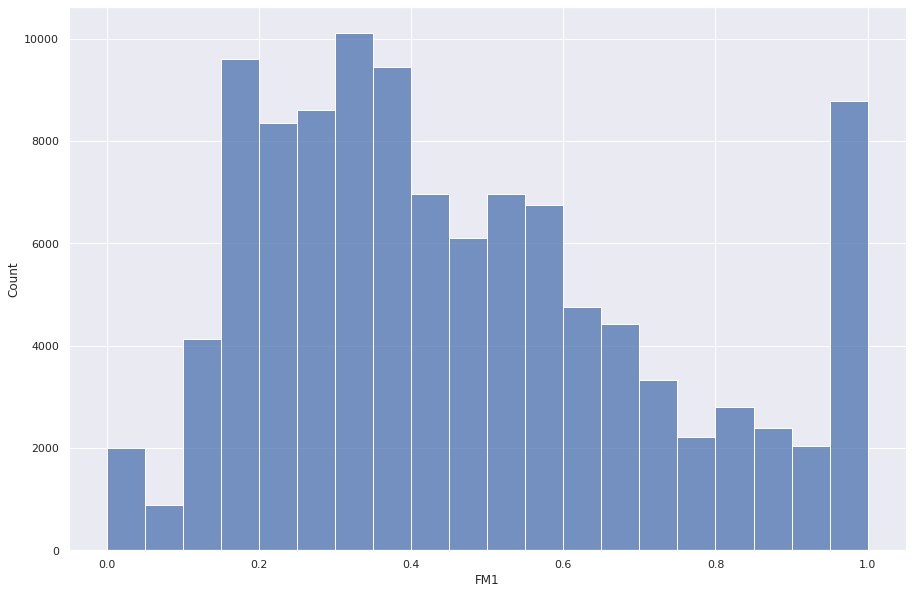

In [7]:
sns.histplot(data = manual, x = "FM1", binwidth = 0.05)

It is clear that the majority of `FM1` values are between ~0.15 and 0.6 so they should be easier to predict given the high volume of data in that range. Values closer to 1 will be harder as there are less examples, but there are some at the max value. So a weighted loss function will be used in training.

In [8]:
def weighted_l1_loss(inp, targ, weight_fn = None):
    """Weighted l1 loss"""
    if weight_fn is not None:
        return (F.l1_loss(*flatten_check(inp,targ), reduction = 'none') * weight_fn(targ)).mean()
    else:
        return F.l1_loss(*flatten_check(inp,targ))

def weight_fn(targ, min = 0, max = 1):
    """Create weighted function"""
    targ = TensorBase(targ.contiguous()).view(-1)
    weight = 1 + torch.clamp((targ - min)/(max - min), 0, 1)
    return weight

loss_func = partial(weighted_l1_loss, weight_fn = weight_fn) # Create the loss function

## **Setting up TSAI/the data**
### Sliding window
The way the data is being split is by using `SlidingWindow`. The way this works is by specifying
* `window_len` - the length of a sequence (in this case 6 is used as we want to predict 3 hours in the future and each data point is 30 minutes)
* `get_x` - the columns to use (indicies of columns used)
* `get_y` - the target column (name used)
* `stride` - how much to move the window by each time (1 is saying move along 30 minutes)
* `horizon` - how far from the last data point to predict (1 is saying to predict the next y after the 3 hour chunk)
* `ascending` - sort by ascending order
* `seq_first` - used as it's a dataframe


Visually a basic example is as such.

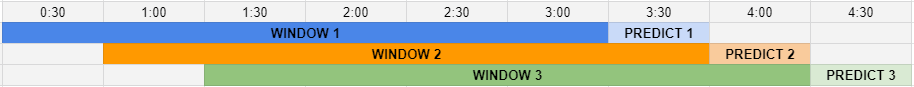

In [9]:
X, y = SlidingWindow(window_len = 6, get_x = [2, 3, 4, 5, 6], get_y = "FM1", start = 0, stride = 1, horizon = 1, sort_by = ["TIME"], ascending = True, seq_first = True)(manual) # Split into windows
X[0:2], y[0:2] # Two examples of windows, notice Xs consist of multiple arrays as there are multiple Xs (each x is a sensor input)

(array([[[0.5384615 , 0.53841573, 0.53836995, 0.5383242 , 0.5382784 ,
          0.5382326 ],
         [0.5384615 , 0.53841573, 0.53836995, 0.5383242 , 0.5382784 ,
          0.5382326 ],
         [0.12307692, 0.12307692, 0.12307692, 0.12307692, 0.12307692,
          0.12307692],
         [0.12307692, 0.12298535, 0.12289377, 0.12280218, 0.12271061,
          0.12261904],
         [0.1428572 , 0.14378719, 0.14471737, 0.14564738, 0.14657737,
          0.14750755]],
 
        [[0.53841573, 0.53836995, 0.5383242 , 0.5382784 , 0.5382326 ,
          0.5381868 ],
         [0.53841573, 0.53836995, 0.5383242 , 0.5382784 , 0.5382326 ,
          0.5381868 ],
         [0.12307692, 0.12307692, 0.12307692, 0.12307692, 0.12307692,
          0.12307692],
         [0.12298535, 0.12289377, 0.12280218, 0.12271061, 0.12261904,
          0.12252747],
         [0.14378719, 0.14471737, 0.14564738, 0.14657737, 0.14750755,
          0.14843754]]]), array([0.99684876, 0.9963235 ]))

### Splits
With the data in "windows" it can now be split into training and validation datasets. It is important to not shuffle the data as the aim is to forecast the future.

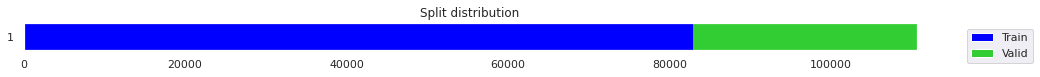

In [10]:
splits = get_splits(y, valid_size = .25, random_state = 23, shuffle = False) # Split

### Dataloaders

After splitting the data, dataloaders can now be created. `TSForecasting` must be declared in `tfms` given the task is to forecast `FM1`. It should also be noted that `shuffle_train` is set to `True`. The reasoning is after researching forecasting problems it is ok to shuffle the training data but the validation data MUST not be shuffled.

In [11]:
tfms  = [None, TSForecasting()]
dls = get_ts_dls(X, y, tfms = tfms, splits = splits, bs = 1024, shuffle_train = True, inplace = True)

Check if the training and validation data is not/is being shuffled appropriately (it is).

In [12]:
dls.train.shuffle, dls.valid.shuffle

(True, False)

Check can be done to see if it is a single input (what is required) before creating a model (it is).

In [13]:
dls.c

1

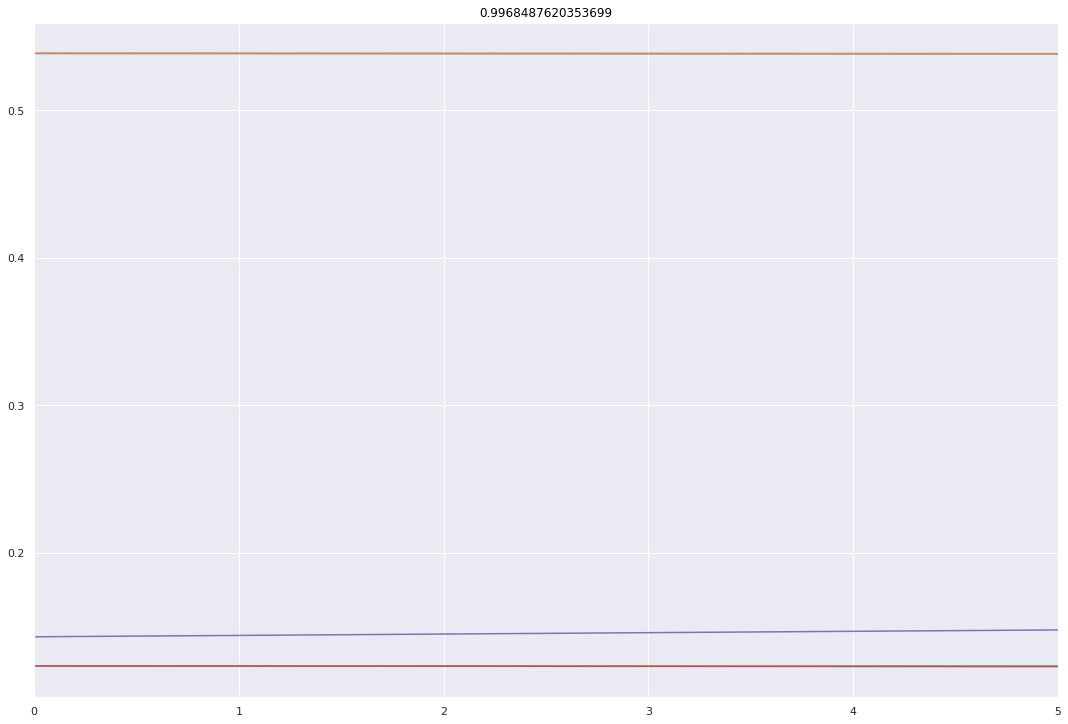

In [14]:
dls.show(dls.train_ds[0]) # A window of data and it's y (future) value

## **Baseline model**
With everything setup a `ts_learner` can be created with inputs:
* The dataloaders - `dls`
* Model architecture - `InceptionTimePlus` (+ parameters `c_in`, `c_out`, `y_range`)
* Metrics - `mae` (important here as y's are between 0 and 1)

`InceptionTimePlus` is a neural network architecture that is commonly used for time series. The architecture has been implemented in `tsai` and is preferred for the baseline given you can specify the range of y values using `y_range`.

In [15]:
learn = ts_learner(dls, InceptionTimePlus, metrics = mae, loss_func = loss_func, c_in = 5, c_out = 1, y_range = [0, 1]) # Create learner

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.00010964782268274575)

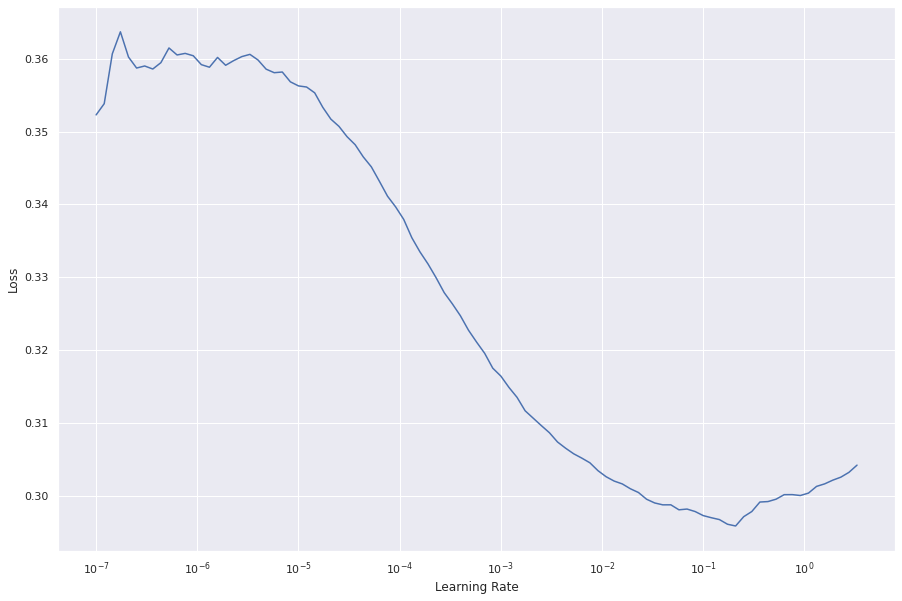

In [16]:
learn.lr_find() # Find suitable lr

epoch,train_loss,valid_loss,mae,time
0,0.357978,0.320472,0.199725,00:02
1,0.347424,0.320297,0.199605,00:02


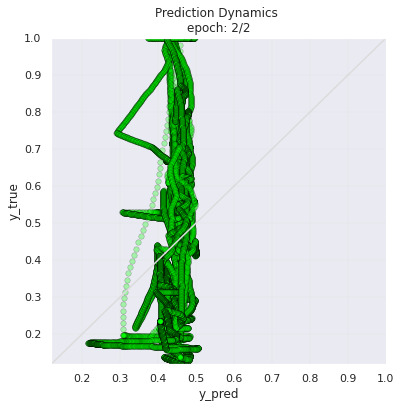

,train_loss,valid_loss,mae
1,0.347424,0.320297,0.199605


epoch,train_loss,valid_loss,mae,time
0,0.338345,0.320883,0.199868,00:02
1,0.334530,0.321291,0.200176,00:02
2,0.330961,0.322033,0.200558,00:02
3,0.326562,0.322928,0.200979,00:02
4,0.321830,0.324425,0.201605,00:02
5,0.317179,0.325558,0.202093,00:02
6,0.311800,0.326832,0.202646,00:02
7,0.306589,0.327000,0.202915,00:02
8,0.302147,0.327265,0.202802,00:02
9,0.296299,0.326743,0.202664,00:02


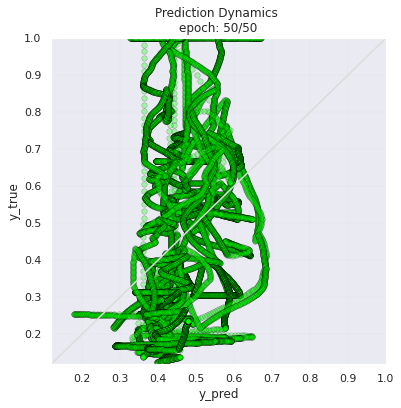

,train_loss,valid_loss,mae
49,0.230229,0.314528,0.197188


In [17]:
# Training loop
# - Fit for 50 epochs
# - Learning rate at 1e-4 (decreasing)
# - Use PredictionDynamics callback to see the predicted vs truths after each epoch/at the end of training
# - Add a tiny bit of weight decay to lessen overfitting
learn.fine_tune(50, 1e-4, freeze_epochs = 2, cbs = PredictionDynamics, wd = 0.05)

In [18]:
def get_residuals(learner, dls):
  # Get predictions and actuals of validation set
  valid_preds, valid_actuals = learner.get_preds(ds_idx = 1, dl = dls.valid)

  # Put the actual against the prediction in a dataframe
  results = pd.DataFrame({"actual" : valid_actuals.flatten().tolist(), 
                          "pred" : valid_preds.flatten().tolist()})

  # Calculate the residual
  results["residual"] = results["actual"] - results["pred"]

  return results

def residual_plot(residuals):
  # Plot the actuals and show the residual, line represents 0 residual i.e. accurate prediction
  fig = sns.scatterplot(data = residuals, x = "actual", y = "residual").set(xlim = (-0.1, 1.1), ylim =(-1.5, 1.5))
  
  return fig

Could not do one pass in your dataloader, there is something wrong in it


[(-1.5, 1.5), (-0.1, 1.1)]

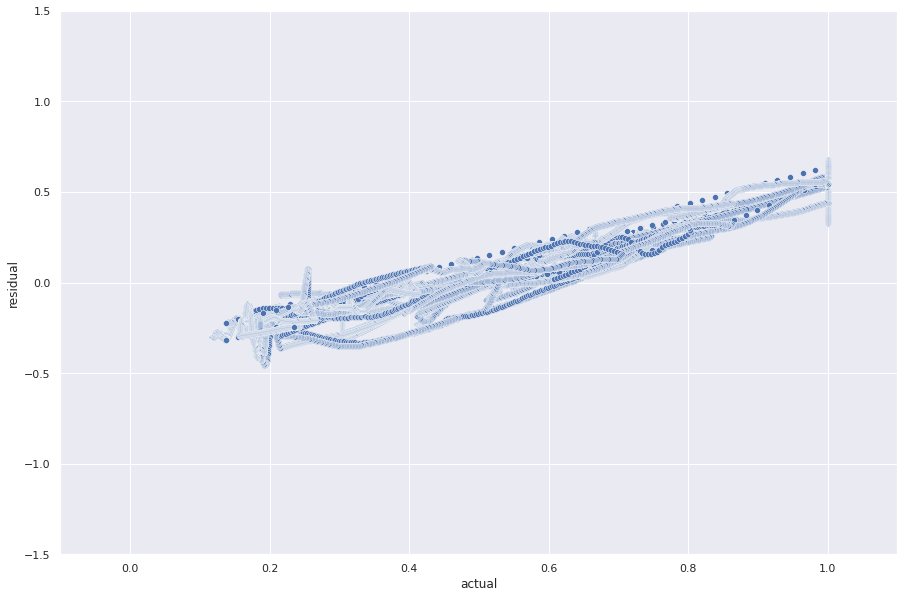

In [19]:
residuals = get_residuals(learner = learn, dls = dls)

residual_plot(residuals)

So `mae` of ~0.2 could potentially be good but given this problem has y values ranging from 0 to 1 that isn't good. Residual plots can be useful to see how the model performs across the different ranges of values. Observations here are broadly

1. It under predicts upper `FM1` 
2. It over predicts lower `FM1`

In the context of the problem it is better to **overpredict** `FM1` given we want to catch high flow rates before they get out of control. So point **1** is an issue.

## **Test with using previous flow rate to predict flow rate**
Rather than using other sensory inputs an alternative approach can be to use previous flow rates to predict the next flow rate. This can be done by replacing `get_x` with `FM1` and making sure horizon is set to 0+. Again splits and dataloaders can be created.

In [20]:
X, y = SlidingWindow(window_len = 6, get_x = "FM1", get_y = "FM1", start = 0, stride = 1, horizon = 1, sort_by = ["TIME"], ascending = True, seq_first = True)(manual) # Split into windows
X[0:2], y[0:2] # Two examples of windows, notice Xs consist of one array as only FM1 not multiple sensors

(array([[[1.        , 0.99947476, 0.9989496 , 0.99842435, 0.9978992 ,
          0.99737394]],
 
        [[0.99947476, 0.9989496 , 0.99842435, 0.9978992 , 0.99737394,
          0.99684876]]]), array([0.99684876, 0.9963235 ]))

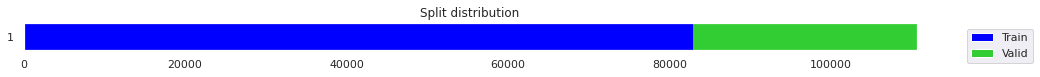

In [21]:
splits = get_splits(y, valid_size = .25, random_state = 23, shuffle = False) # Split

In [22]:
tfms  = [None, TSForecasting()]
dls = get_ts_dls(X, y, tfms = tfms, splits = splits, bs = 1024, shuffle_train = True, inplace = True)

### Model
I've changed the model hear after some experiementation with InceptionTime architectures. This input data worked better with `InceptionTimePlus` which is similar to `InceptionTime` but it has a few more inputs, specifically setting the target range using `y_range`. However this architecture didn't work well with the other input data.

In [23]:
learn = ts_learner(dls, InceptionTimePlus, metrics = mae, loss_func = loss_func, c_in = 1, c_out = 1, y_range = [0, 1])

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=4.365158383734524e-05)

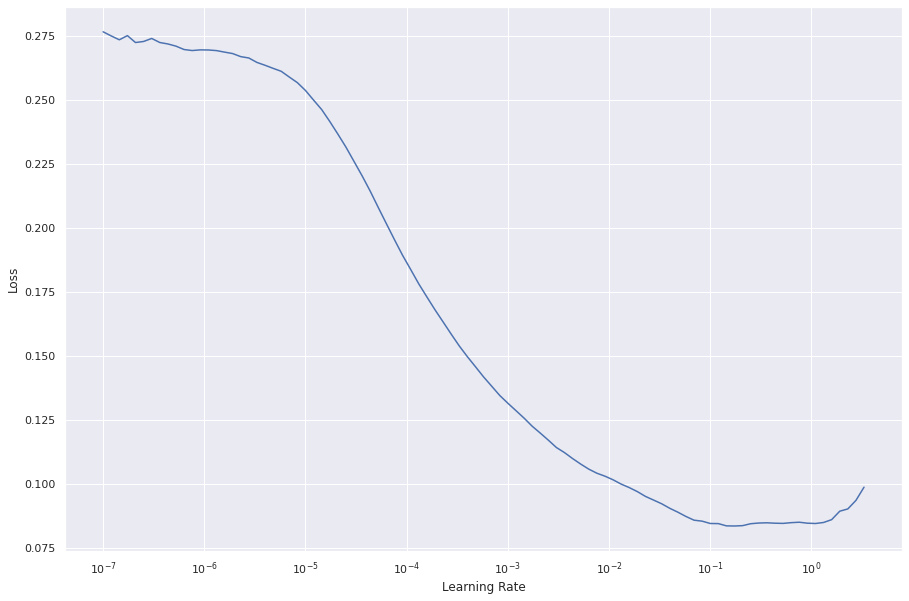

In [24]:
learn.lr_find()

epoch,train_loss,valid_loss,mae,time
0,0.270465,0.248305,0.162588,00:02
1,0.253856,0.231219,0.150247,00:02
2,0.211704,0.170855,0.112558,00:02
3,0.146887,0.096185,0.064180,00:02
4,0.083395,0.046728,0.028930,00:02


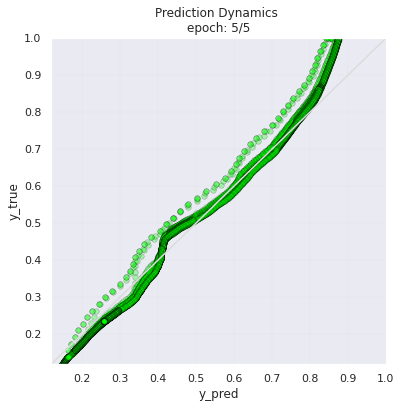

,train_loss,valid_loss,mae
4,0.083395,0.046728,0.02893


epoch,train_loss,valid_loss,mae,time
0,0.043993,0.037532,0.022727,00:02
1,0.037353,0.028486,0.016534,00:02
2,0.031460,0.024021,0.013845,00:02
3,0.028052,0.021517,0.012366,00:02
4,0.024953,0.017872,0.010147,00:02
5,0.022605,0.016508,0.009374,00:02
6,0.020423,0.014762,0.008508,00:02
7,0.019473,0.013231,0.007590,00:02
8,0.018593,0.011263,0.006316,00:02
9,0.016961,0.010332,0.005830,00:02


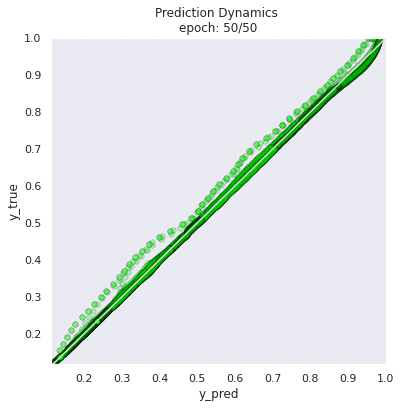

,train_loss,valid_loss,mae
49,0.012256,0.005803,0.003345


In [25]:
learn.fine_tune(50, 0.0001, freeze_epochs = 5, cbs = PredictionDynamics, wd = 0.01)

Both losses have decreased with no obvious signs of overfitting!

### Residual check

Could not do one pass in your dataloader, there is something wrong in it


[(-1.5, 1.5), (-0.1, 1.1)]

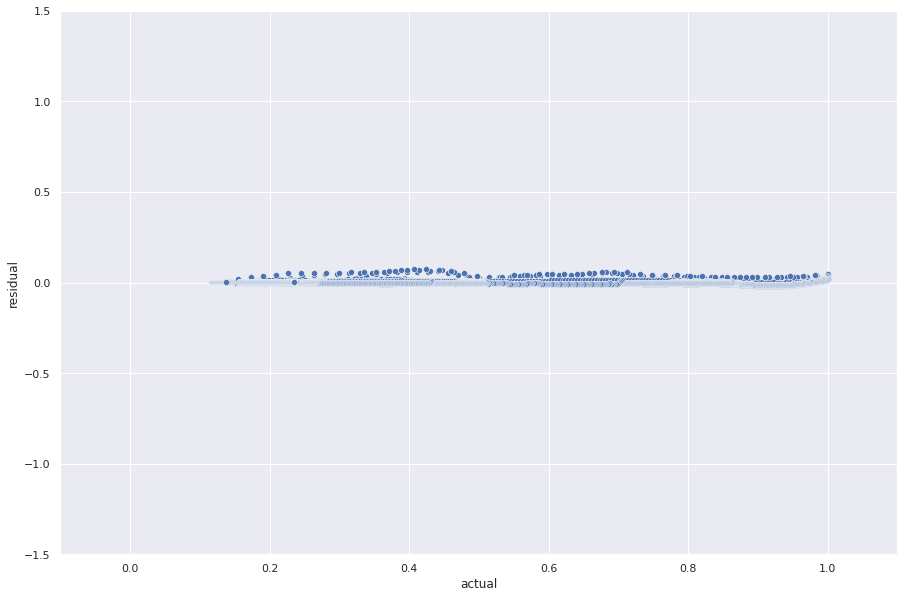

In [26]:
residuals = get_residuals(learner = learn, dls = dls)

residual_plot(residuals)

With an alternative approach the results have been improved significantly with a large decrease to residuals.

## **Closing thoughts**
Although there are more traditional forecasting methods e.g. moving average, neural networks can be powerful and quick to train for similar tasks. Even using a fairly simplistic idea of taking previous values of the target in a "window" of time, the results can be high performing.

There's a lot to explore with `tsai` e.g. calculating an Y's using a function such as take the max value of the next 5 time steps and predict that per window, this is a basic example.